# import data and libraries

- download data from google drive to kaggle 
- unzip data
- upgrade torch, torchtext, torchvision and nltk libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
! pip install -q gdown

In [ ]:
! gdown 'https://drive.google.com/u/0/uc?id=1AoiQCXqFbqETGILCpgFgozYJvmyGfq_9&export=download'

In [ ]:
! gdown 'https://drive.google.com/u/0/uc?id=1zmdERncg0zcrqpdCzOzth0exYevXxEp2&export=download'

In [ ]:
! unzip './AFEC-merged-all.zip'

In [ ]:
!unzip './Test.zip'

In [ ]:
! pip install -q i 

In [ ]:
!pip install --upgrade torchtext

In [ ]:
!pip install --upgrade torch torchvision

In [ ]:
!pip install --upgrade nltk

# Data preprocessing

- read data line by line
- create a pandas data frame
- split data to train (90%) and validation (10%)
- save train and validation data frames

> with help of this [tutorail](https://youtu.be/DaHAzCaXWYQ)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
text_fa = open('./AFEC-merged.fa', encoding='utf8').read().splitlines()
text_eng =  open('./AFEC-merged.en', encoding='utf8').read().splitlines()

In [ ]:
persian_english_text = {'English':text_eng, 'Persian':text_fa}

In [ ]:
df =pd.DataFrame(persian_english_text, columns=['English', 'Persian'])
df

,English,Persian
0,North Waziristan operation kills 50 more milit...,مرگ 50 ستیزه جوی دیگر در عملیات وزیرستان شمالی
1,PESHAWAR - The on - goingmilitary operation in...,"پیشاور - به گزارش جیو نیوز , عملیات ادامه دار ..."
2,The Pakistani Air Force conducted airstrikes a...,"به گزارش رسانه‌ها , نیروی هوایی پاکستان حملات ..."
3,"A day earlier , at least 27 militants were rep...",یک روز پیشتر گزارش شده بود که دست کم 27 ستیزه ...
4,"Meanwhile , a roadside blast on Bangidar road ...","در ضمن , مسئولان گفتند که یک انفجار کنارجاده ا..."
...,...,...
684412,that is an excellent idea . when is your birth...,این یک فکر عالی است . تولد شما کی است ?
684413,"fine , then we will go back by train to Hambur...","خوب , بنابراین ما با قطار در سه و سی و سه دقیق..."
684414,"well , I think , eight o ' clock in the evenin...","خوب , من فکر میکنم , ساعت هشت بعداز ظهر کافی ا..."
684415,there is a train at thirty-three past six o ' ...,یک قطار برای ساعت شش و سی و سه دقیقه وجود دارد...


In [ ]:
train, validation = train_test_split(df, test_size=0.1)

In [ ]:
train.to_csv('train.csv', index=False)
validation.to_csv('validation.csv', index=False)

# Create dataset and dataloaders

- create persian and english tokenizer functions
- create 2 Field for persian and english
- create training and validation data from train and validation data frames
- build vocabulary for 2 langages with frequency threshold of 5 and maximum size of 20000
- craete train and validation data loaders with batch size of 64




> with help of this [tutorail](https://youtu.be/DaHAzCaXWYQ)

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## craete tokenizer functions by pyonmttok
-  train a BPE tokenizer on each language sentences
- use trained BPE tokenizer as a tokenization Function

### English BPE tokenizer

In [ ]:
import pyonmttok
# BPE is trained and applied on the tokenization output before joiner (or spacer) annotations.
tokenizer_english = pyonmttok.Tokenizer("aggressive", joiner_annotate=True, segment_numbers=True)
learner = pyonmttok.BPELearner(tokenizer=tokenizer_english, symbols=32000)

In [ ]:
for i in range(len(text_eng)):
  learner.ingest(text_eng[i])

In [ ]:
tokenizer_english = learner.learn("model-32k")

### Persian BPE tokenizer

In [ ]:
# BPE is trained and applied on the tokenization output before joiner (or spacer) annotations.
tokenizer_persian = pyonmttok.Tokenizer("aggressive", joiner_annotate=True, segment_numbers=True)
learner_fa = pyonmttok.BPELearner(tokenizer=tokenizer_persian, symbols=32000)


In [ ]:
for i in range(len(text_fa)):
  learner_fa.ingest(text_fa[i])


In [ ]:
tokenizer_persian = learner_fa.learn("model_fa-32k")

In [ ]:
import re
def tokenizer_fa(text):
  text = re.sub("(\\u200c|\\xad)", " ", text)
  tokens, _ = tokenizer_persian.tokenize(text)
  return tokens
def tokenizer_eng(text):
  tokens, _ = tokenizer_english.tokenize(text)
  return [token.lower() for token in tokens]

## create Dataloaders

In [ ]:
import torch
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

In [ ]:
english = Field(sequential=True, use_vocab=True, tokenize=tokenizer_eng, lower=True, init_token='<SOS>', eos_token='<EOS>', batch_first=True)
persian = Field(sequential=True, use_vocab=True, tokenize=tokenizer_fa, init_token='<SOS>', eos_token='<EOS>',  batch_first=True)


In [ ]:
fields = {'English':('eng', english), 'Persian':('fa', persian)}

In [ ]:
train_data, validation_data = TabularDataset.splits(
    path='',
    train = 'train.csv',
    validation = 'validation.csv',
    format='csv',
    fields=fields
)

In [ ]:
english.build_vocab(train_data,max_size= 20000, min_freq=5)
persian.build_vocab(train_data,max_size= 20000, min_freq=5)

In [ ]:
train_iterator, validation_iterator = BucketIterator.splits(
    (train_data, validation_data),
    batch_size=64,
    sort=False,
    shuffle=True
    )

# Create Model
- define positional encoding, word embedding, position wise feedforward, multihead attention modules
- create encoder layer
- create encoder cosist of multiple encoder layers
- create decoder cosist of multiple decoder layers usinf torch modules
- create transformer model

In [ ]:
from torch import Tensor
import torch
import torch.nn as nn
import torch.optim as optim
import  torch.nn.functional as F
from torch.autograd import Variable

import math
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## positional encoding
- embedding size of 256
- dropout rate = 0.1
- max length of positional encoding tensor = 200

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 200):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        # sum of tokekn embeding and positional encoding
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


## Embedding
- map word vectors to embedding with size of 256

In [ ]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        # token embedding * scale
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


## position wise feed forward

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x): 
        x = self.dropout(torch.relu(self.fc_1(x))) # (batch size, seq len, hid dim)
        x = self.fc_2(x) # (batch size, seq len, pf dim)
        return x # (batch size, seq len, hid dim)

## Multihead attention
- calculate attention by scaled dot product using key, value and Query

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        #assert hid_dim % n_heads == 0
        self.hid_dim = hid_dim # embedding size or d_model
        self.n_heads = n_heads  # number of heads
        self.head_dim = hid_dim // n_heads # value dim = Query dim
        self.fc_q = nn.Linear(hid_dim, hid_dim) # Query
        self.fc_k = nn.Linear(hid_dim, hid_dim) # Key
        self.fc_v = nn.Linear(hid_dim, hid_dim) # Value
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device) # scale for energy in scaled dot product
  
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]

        Q = self.fc_q(query) # (batch size, query len, hid dim)
        K = self.fc_k(key) # (batch size, query len, hid dim)
        V = self.fc_v(value) # (batch size, query len, hid dim)
     
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) # (batch size, n heads, query len, head dim)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) # (batch size, n heads, key len, head dim)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) # (batch size, n heads, value len, head dim)
    
        # Scaled Dot Product
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale # (batch size, n heads, query len, key len)
        # apply mask for paddings in source sentence
        if mask is not None:
            energy = energy.masked_fill(mask == 1,  float("-inf"))
        attention = torch.softmax(energy, dim = -1) # (batch size, n heads, query len, key len)
        x = torch.matmul(self.dropout(attention), V) # (batch size, n heads, query len, head dim)
        x = x.permute(0, 2, 1, 3).contiguous() # (batch size, query len, n heads, head dim)
        x = x.view(batch_size, -1, self.hid_dim) # (batch size, query len, hid dim)
        x = self.fc_o(x) # (batch size, query len, hid dim)
        return x

## creating encoder layer

- multihead attention
- add (residual) and layer Norm
- positionwise feed forward
- add (residual) and layer Norm

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim, eps = 1e-05)
        self.ff_layer_norm = nn.LayerNorm(hid_dim,  eps = 1e-05)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #self attention
        _src = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        return src

## Encoder

- token embedding + positional encoding
- encdoer layer (multihead attention + add and norm + position wise feed forward + add and norm)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 200):
        super().__init__()
        self.device = device
        self.src_tok_emb = TokenEmbedding(input_dim, hid_dim)
        self.positional_encoding = PositionalEncoding(hid_dim, dropout=dropout)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device) for _ in range(n_layers)])
        
    def forward(self, src, src_mask):
        src = self.positional_encoding(self.src_tok_emb(src)).to(device)
        for layer in self.layers:
            src = layer(src, src_mask)
        return src

## Decoder
- token embedding + positional encoding
- Decoder layer of pytorch


In [ ]:
class Decoder(nn.Module):
    def __init__(self, trg_vocab_size, embed_size, N, heads, dropout=0.1):
        super().__init__()
        self.N = N
        self.tgt_tok_emb = TokenEmbedding(trg_vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, dropout=dropout)
        self.layers = nn.ModuleList([nn.TransformerDecoderLayer(embed_size, heads, batch_first=True, layer_norm_eps = 1e-05) for i in range(N)])
    
    def forward(self, tgt, e_outputs, tgt_key_padding_mask, tgt_mask):
        tgt = self.positional_encoding(self.tgt_tok_emb(tgt)).to(device)
        for i in range(N):
            x = self.layers[i](tgt, e_outputs, tgt_mask = tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        return x

## Transformer Model

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, device):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads,pf_dim=1024, dropout=0.1, device=device)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, trg_vocab)
        self.softmax= nn.Softmax()
        self.trg_pad_idx = 1
        self.src_pad_idx =1
        self.device = device

    def make_src_mask(self, src):       
        src_mask = (src == self.src_pad_idx)
        return src_mask
    
    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def create_mask(self, src, tgt):
        tgt_seq_len = tgt.shape[1]
        tgt_mask = self.generate_square_subsequent_mask(tgt_seq_len)
        tgt_padding_mask = (tgt == 1)
        return tgt_mask ,tgt_padding_mask 

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask, tgt_padding_mask = self.create_mask(src, trg)
        e_outputs = self.encoder(src, src_mask.unsqueeze(1).unsqueeze(2))
        d_output = self.decoder(trg, e_outputs, tgt_padding_mask, trg_mask)
        output = self.out(d_output)
        return output

# Define a transformer model

In [ ]:
d_model = 256
heads = 8
N = 3
src_vocab = len(english.vocab)
trg_vocab = len(persian.vocab)
model = Transformer(src_vocab, trg_vocab, d_model, N, heads,device)
# initialize with Xavier initialization to prevent gradient problems (vanishing or exploding)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [ ]:
model.to(device)

Transformer1(
  (encoder): Encoder(
    (src_tok_emb): TokenEmbedding(
      (embedding): Embedding(20004, 256)
    )
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=1024, bias=True)
          (fc_2): Linear(in_feat

# Train and validate Model

In [ ]:
LEARNING_RATE = 0.0001
criterion = nn.CrossEntropyLoss(ignore_index = 1) # padding index is 1 for both languages
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE,  betas=(0.9, 0.98), eps=1e-9)

In [ ]:
def train_model(epochs,max_iter):
    train_loss = []
    valid_loss = []
    iter = 0
    total_loss = 0
    for epoch in range(epochs):
        epoch_loss=0
        for i, batch in enumerate(train_iterator):
            model.train()
            iter+=1
            src = batch.eng.to(device)
            trg = batch.fa.to(device)
            optimizer.zero_grad()
        
            output = model(src, trg[:,:-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            loss = criterion(output, trg)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1) # clip gradient to prevent vanishing
            optimizer.step()
            epoch_loss += loss.item() 
            # validate every 200 iteration
            if iter%200 ==0 :
              val_loss = 0
              model.eval()
              with torch.no_grad():
                for j, batch in enumerate(validation_iterator):
                  src = batch.eng.to(device)
                  trg = batch.fa.to(device)
                  output = model(src, trg[:,:-1])
                  output_dim = output.shape[-1]
                  output = output.contiguous().view(-1, output_dim)
                  trg = trg[:,1:].contiguous().view(-1)
                  loss = criterion(output, trg)
                  val_loss += loss.item()
                # print train and validation loss
                print(f' epoch:{epoch} - iteration:{iter} - train loss:{epoch_loss/(i+1)} - val loss:{val_loss/(j+1)}')
                torch.save(model.cpu().state_dict(), 'final_model.pth') # saving model
                model.to(device)
                train_loss.append(epoch_loss/(i+1))
                valid_loss.append(val_loss/(j+1))
            # fininsh training if reach max iteration
            if iter==max_iter :
              print('finish training!')
              break
        if iter==max_iter:
          break
    return train_loss, valid_loss

In [ ]:
train_loss, valid_loss = train_model(12, 68000)

 epoch:0 - iteration:200 - train loss:7.896258006095886 - val loss:6.890741557718437
 epoch:0 - iteration:400 - train loss:7.264234791994095 - val loss:6.330566448140367
 epoch:0 - iteration:600 - train loss:6.89092343489329 - val loss:5.958626418247401
 epoch:0 - iteration:800 - train loss:6.62704486489296 - val loss:5.735162189964936
 epoch:0 - iteration:1000 - train loss:6.434420331478119 - val loss:5.58832673179769
 epoch:0 - iteration:1200 - train loss:6.28602364619573 - val loss:5.470906145327559
 epoch:0 - iteration:1400 - train loss:6.163895274911608 - val loss:5.359839007119152
 epoch:0 - iteration:1600 - train loss:6.05933445096016 - val loss:5.282641337296673
 epoch:0 - iteration:1800 - train loss:5.9699502046902975 - val loss:5.197603493093331
 epoch:0 - iteration:2000 - train loss:5.889912142515183 - val loss:5.131369146454
 epoch:0 - iteration:2200 - train loss:5.818554910312999 - val loss:5.073108841994099
 epoch:0 - iteration:2400 - train loss:5.75427679002285 - val los

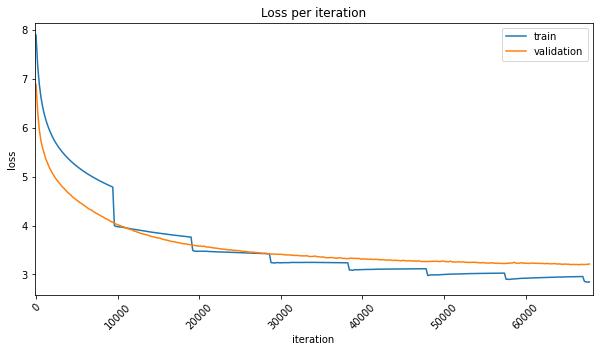

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
plt.title('Loss per iteration')
plt.xlabel('iteration')
#plt.xticks([i for i in range(200, (len(train_loss)+1)*200,200)])
plt.ylabel('loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='validation')
plt.xticks(rotation=45)
locs, labels = plt.xticks()
labels = [(int(item))*200 for item in locs]
plt.xticks(locs, labels)
plt.xlim(xmin=-0.9, xmax = (len(train_loss)+1))
plt.legend()
plt.show()

# Test and evaluate Model

In [ ]:
test_text_fa0 = open('./Test/test.fa0', encoding='utf8').read().splitlines()
test_text_fa1 = open('./Test/test.fa1', encoding='utf8').read().splitlines()
test_text_fa2 = open('./Test/test.fa2', encoding='utf8').read().splitlines()
test_text_fa3 = open('./Test/test.fa3', encoding='utf8').read().splitlines()
test_text_eng =  open('./Test/test.en', encoding='utf8').read().splitlines()

## Translation Function
- based on greedy search

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):  
    model.eval()
    tokens = nltk.word_tokenize(sentence.lower()) # tokenize source sentence
    tokens = [src_field.init_token] + tokens + [src_field.eos_token] # add <SOS> and <EOS>
    src_indexes = [src_field.vocab.stoi[token] for token in tokens] # map tokens to index in source vocab
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor) # make mask for if there is padding
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask) # output of encoder
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]] # strat translation with <SOS> token
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask, tgt_padding_mask = model.create_mask(src_tensor, trg_tensor) 
        with torch.no_grad():
          output = model.decoder(trg_tensor, enc_src, tgt_padding_mask, trg_mask)
          output = model.out(output)   
        pred_token = output.argmax(2)[:,-1].item() # select maximum probable token due to gready search
        trg_indexes.append(pred_token)
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    return trg_tokens[1:]

## test translate function

In [ ]:
src = test_text_eng[43] # 43, 88
print(src)

I did not understand , what you said about the hotel .


In [ ]:
trg  = translate_sentence(src, english, persian, model, device, max_len = 50)
print(" ".join(trg[:-1]))

من گفتم که هتل را متوجه شدم که شما چیست .


## calculate BLUE and NIST score

In [ ]:
from nltk.translate import nist_score

In [ ]:
test_sentences =  [sentence for sentence in test_text_eng]
refrences = [[tokenizer_fa(test_text_fa0[i]), tokenizer_fa(test_text_fa1[i]), tokenizer_fa(test_text_fa2[i]), tokenizer_fa(test_text_fa3[i])] for i in range(len(test_text_fa3))]
test_results=[]

In [ ]:
blue_scores = []
Nist_score = []
for i in range(len(test_sentences)):
  src = test_sentences[i]
  trg  = translate_sentence(src, english, persian, model, device, max_len = 50)
  test_results.append(trg[:-1])
  blue_scores.append(nltk.translate.bleu_score.corpus_bleu([refrences[i]], [trg[:-1]]))
  try:
    Nist_score.append(nist_score.corpus_nist([refrences[i]], [trg[:-1]]))
  except ZeroDivisionError:
    Nist_score.append(0)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [ ]:
print(f'mean BLUE: {np.mean(blue_scores)}')

mean BLUE: 0.13570392186021452


In [ ]:
print(f'mean NIST: {np.mean(Nist_score)}')

mean NIST: 1.8309096441259844


## Some of translations

In [ ]:
for i in range(30):
    sentence = test_sentences[i]
    translation = " ".join(test_results[i])
    print(f'{i}: original sentence: {sentence} \ntranslation: {translation}')

0: original sentence: hello , do we drive together to Hanover on the twenty-eighth of March ? 
translation: سلام , ما با هم در حال حرکت هستیم , آیا با هم در روز با هم با هم در هانوور صحبت کنیم ?
1: original sentence: it is more comfortable by train . 
translation: آموزش های بیشتری با قطار است .
2: original sentence: do you go by car and I go by train ? 
translation: می روم با ماشین و با ماشین می روم ?
3: original sentence: I would like to go by train . and what would you like ? 
translation: و من دوست دارم با قطار ? و به شما می روم .
4: original sentence: if we take the $I-$C-$E train at six past seven , we will arrive at twenty-five past eight . 
translation: اگر ما هفت دلار می توانیم هشت دلار در گذشته به قطار سریع السیر <unk> , هفت دلار برسد , هشت دلار خواهیم رسید .
5: original sentence: which cafe ? 
translation: که به آن کافه می آیند ?
6: original sentence: the cafe at platform fourteen . 
translation: چهارده ساله در کافه می باشد .
7: original sentence: in any case a cheap hotel . 